This model uses stochastic gradient descent as the learning algorithm. The underlying model is the convolutional neural network approach which considers the neighborhood information and context.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
import random
import math

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def make_image(output, shape):
    images = np.reshape(output, shape)
    plt.figure()
    plt.imshow(images)

In [0]:
def convert_output_image(img_flattened, img_shape):
      cols = img_flattened.shape[1]
      print(cols)
      print(img_shape)
      img = np.full((img_shape[0], img_shape[1], img_shape[2]), None, dtype = "float")
      for i in range(cols):
        row = math.floor(i/img_shape[1])
        col = i % img_shape[1]
        for k in range(3):
          img[row][col][k] = img_flattened[k][i]
      return img

In [0]:
class NeuralNetwork:
    def __init__(self, x, y, num_hidden, epochs,batch_epochs, learning_rate, num_nodes_layers, activation_function, batch_size):
        self.x = x
        self.y = y

        self.n_x = x.shape[0] 
        self.n_out = y.shape[0]

        self.batch_size = batch_size
        self.activation_function = activation_function
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_epochs = batch_epochs
        self.num_hidden = num_hidden
        self.num_layers = num_hidden + 1  # +1 for output layer

        self.num_nodes_layers = num_nodes_layers
        # inserting input and output nodes to the list
        self.num_nodes_layers.insert(0, self.n_x)
        self.num_nodes_layers.append(self.n_out)

        self.leaky_slope = 0.01
        self.weights = []
        self.bias = []

    # parameters: weight and bias
    # weight[l] : (num_layers * num_layers-1 ) * num_layers : (no. of nodes in layer l * no. of nodes in layer (l-1)) * no. of layers
    # bias[l]: () : ( no. of nodes in layer * 1) * no. of layers
    def initialize_parameters_random(self):
        for l in range(1, self.num_layers + 1):
            self.weights.append(
                np.random.rand(self.num_nodes_layers[l], self.num_nodes_layers[l - 1]))
            self.bias.append(np.full((self.num_nodes_layers[l], 1), 1))

    # Use this when activation function is tanh or sigmoid
    def initialize_parameters_xavier(self):

        for l in range(1, self.num_layers + 1):
            # print("l =", l)
            # print(self.num_nodes_layers[l] , self.num_nodes_layers[l-1])
            self.weights.append(np.random.randn(self.num_nodes_layers[l], self.num_nodes_layers[l - 1]) * np.sqrt(
                1 / self.num_nodes_layers[l - 1]))
            self.bias.append(np.full((self.num_nodes_layers[l], 1), 1))

    # Use this when activation function is ReLU or Leaky ReLu
    def initialize_parameters_he(self):
        for l in range(1, self.num_layers + 1):
            self.weights.append(np.random.randn(self.num_nodes_layers[l], self.num_nodes_layers[l - 1]) * np.sqrt(
                2 / self.num_nodes_layers[l - 1]))
            self.bias.append(np.full((self.num_nodes_layers[l], 1), 1))

    # Activation Functions
    def activation(self, x):
        if self.activation_function == "linear":
            return x
        if self.activation_function == "sigmoid":
            return 1.0 / (1.0 + np.exp(-x))
        elif self.activation_function == "tanh":
            return np.tanh(x)
        elif self.activation_function == "relu":
            a = np.zeros_like(x)
            return np.maximum(a, x)
        elif self.activation_function == "leaky_relu":
            a = self.leaky_slope * x
            return np.maximum(a, x)

    def gradient_activation(self, X):
        if self.activation_function == "linear":
            return np.ones_like(X)
        elif self.activation_function == "sigmoid":
            return self.activation(X) * (1 - self.activation(X))
        elif self.activation_function == "tanh":
            return (1 - np.square(X))
        elif self.activation_function == "relu":
            grad = np.zeros_like(X)
            grad[X > 0] = 1.0
            return grad
        elif self.activation_function == "leaky_relu":
            grad = np.ones_like(X)
            grad[X <= 0] = self.leaky_slope
            return grad

    def forward_propogation(self, x):
        # dim of A vector: (no. of hidden nodes * num_data) *(no. of layers)
        A = []
        Z = []
        A.append(x)
        A_prev = x

        for l in range(0, self.num_layers):
            z = np.matmul(self.weights[l], A_prev)
            a = self.activation(z)
            A_prev = a
            A.append(a)
            Z.append(z)
        return (A, Z)


    def loss_function(self, y, out):
        return (0.5 * np.sum((y - out) ** 2))

    def back_propogation(self, A, Z, y):

        delta_z = [None for i in range(self.num_layers)]
        delta_weight = [None for i in range(self.num_layers)]

        delta_z[-1] = (y - A[-1])
        delta_weight[-1] = np.matmul(delta_z[-1],  A[-2].T)

        for l in range(self.num_layers - 2, -1, -1):
            delta_z[l] = np.multiply(np.matmul(self.weights[l + 1].T, delta_z[l + 1]), self.gradient_activation(Z[l]) )
            delta_weight[l] = np.matmul( delta_z[l], A[l].T )

        return delta_weight

    def update_weight(self, A, delta_weight):
        # weight = weight + learning_rate * error * input
        m = A[-1].shape[1]

        for l in range(self.num_layers):
            self.weights[l] = self.weights[l] + (self.learning_rate * delta_weight[l])/m

    def predict(self, x_test):
        A,Z = self.forward_propogation(x_test)
        prediction = A[-1]
        # print(prediction)

        return prediction


    def model(self):

        initializing parameters
        if (self.activation_function in ["tanh", "sigmoid"]):
            self.initialize_parameters_xavier()
        elif (self.activation_function in ["relu", "leaky_relu"]):
            self.initialize_parameters_he()
        else:
        self.initialize_parameters_random()

        for e in range(self.epochs):

            loss = []
            n_images = len(self.x[0,:])
            
            for j in range(n_images):
                x = self.x[:, j]
                y = self.y[:, j]
                
                x = np.reshape(x,(x.shape[0],1))
                y = np.reshape(y,(y.shape[0],1))

                A, Z = self.forward_propogation(x)     
                delta_weight = self.back_propogation(A, Z, y)
                self.update_weight(A, delta_weight)

                prediction = self.predict(x)
                loss.append(self.loss_function(prediction, y))
                
            if e%10 == 0:
                print("Epoch = ", e)
                print("loss = ", np.mean(loss))

In [0]:
def image_to_grayscale(input_image):
    input_image_size = input_image.shape
    num_row = input_image_size[0]
    num_col = input_image_size[1]

    r = input_image[:,:,0]
    g = input_image[:,:,1]
    b = image_image[:,:,2]

    grayscale_image = 0.21*r + 0.72*g + 0.07*b

    grayscale_image = np.asarray(grayscale_image)
    return grayscale_image

In [0]:
def image_to_batch(img, window_size = 5, stride = 1):

    gray = image_to_grayscale(img)

    padding = int((window_size - 1)/2)
    padded_img = np.zeros((2 * padding + gray.shape[0], 2 * padding + gray.shape[1]))
    padded_img[padding:-padding,padding:-padding] = gray

    rows = gray.shape[0]
    cols = gray.shape[1]
    input_batch = []
    output_batch = []
    for i in range(0,rows,stride):
        for j in range(0,cols,stride):
            window = padded_img[i:i+window_size,j:j+window_size]
            input_batch.append(window.flatten())
            output_batch.append(img[i,j,:])
    input_batch = np.asarray(input_batch).T
    output_batch = np.asarray(output_batch).T
    
    return input_batch, output_batch

In [0]:
def split_data(images, window_size = 5, stride = 1):

    train_data = []
    train_output = []
    test_data = []
    test_output = []

    for img in images:
        
        input_batch, output_batch = image_to_batch(img, window_size, stride)
        
        choice = random.random()
        if choice < 1:
            train_data.append(input_batch)
            train_output.append(output_batch) 
        # else:
            test_data.append(input_batch)
            test_output.append(output_batch) 
            
    train_data = (np.asarray(train_data))  
    train_output = (np.asarray(train_output))
    test_data = (np.asarray(test_data))
    test_output = (np.asarray(test_output))
    
    
    return (train_data, train_output), (test_data, test_output)

In [0]:
def get_data(directory_in_str):
    images = []
    directory = os.fsencode(directory_in_str)
    count = 1

    for file in os.listdir(directory):
        path = os.path.join(directory, file)
        filename = os.fsdecode(path)

        img = mpimg.imread(filename)
        images.append(np.asarray(img))
        count+=1

    return images

In [0]:
window_size = 3
stride = 1
THIS_FOLDER = os.path.dirname("/content/drive/My Drive/Projects/520 (Intro to AI) - Projects/Colorization (Project 4)/Working Directory/apple_dataset")
print(THIS_FOLDER)
my_file = os.path.join(THIS_FOLDER, 'Google data classes/Trees')
images = get_data(my_file)

(x_train, y_train), (test_data, test_output) = split_data(images, window_size,stride)

x_train = np.array(x_train.transpose(1,0,2).reshape(window_size*window_size,-1), dtype = "float")
y_train = np.array(y_train.transpose(1,0,2).reshape(3,-1), dtype = "float")
print("X train shape",x_train.shape)
print("Y train shape",y_train.shape)

test_data = np.array(test_data.transpose(1,0,2).reshape(window_size*window_size,-1), dtype = "float")
test_output = np.array(test_output.transpose(1,0,2).reshape(3,-1), dtype = "float")

test_imgs = []
test_outs = []
img_cols = images[0].size/3

for i in range(int(test_data.shape[1]/img_cols)):
    test_imgs.append(test_data[:, int(i * img_cols) : int((i + 1) * img_cols)])
    test_outs.append(test_output[:, int(i * img_cols) : int((i + 1) * img_cols)])

for i in range(len(x_train[0])):
    x_train[:,i] = x_train[:,i]/255.0
    y_train[:,i] = y_train[:,i]/255.0

nn = NeuralNetwork(x_train, y_train, num_hidden= 1, epochs= 50, batch_epochs = 1, learning_rate=0.125, num_nodes_layers=[9],
                    activation_function="sigmoid", batch_size = 1)
nn.model()

/content/drive/My Drive/Projects/520 (Intro to AI) - Projects/Colorization (Project 4)/Working Directory
X train shape (9, 405000)
Y train shape (3, 405000)
Epoch =  0
loss =  97.47372980847805
Epoch =  10
loss =  42.73250739440553
Epoch =  20
loss =  42.02920954543637
Epoch =  30
loss =  41.65682811142663
Epoch =  40
loss =  41.23011457708465


10
50625
(225, 225, 3)
50625
(225, 225, 3)


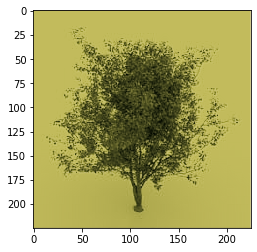

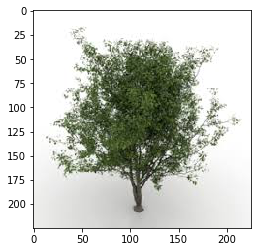

11
50625
(225, 225, 3)
50625
(225, 225, 3)


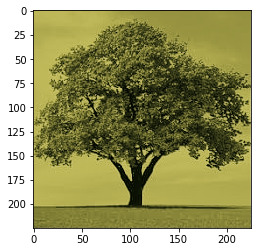

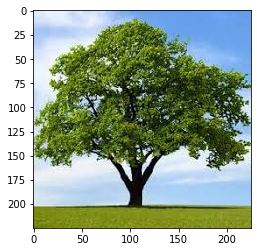

12
50625
(225, 225, 3)
50625
(225, 225, 3)


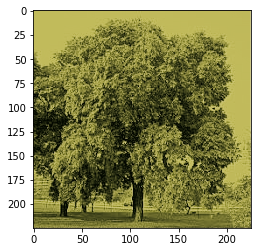

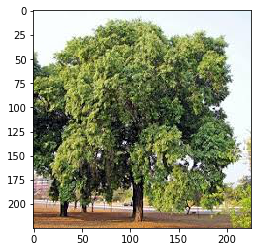

13
50625
(225, 225, 3)
50625
(225, 225, 3)


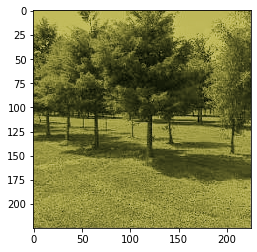

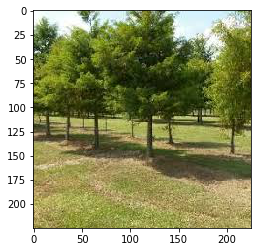

14
50625
(225, 225, 3)
50625
(225, 225, 3)


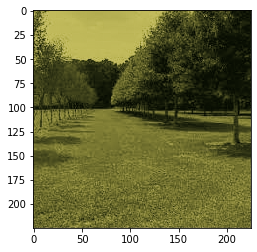

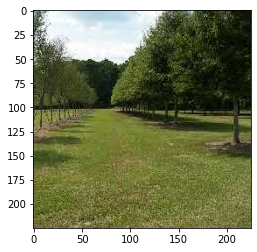

15
50625
(225, 225, 3)
50625
(225, 225, 3)


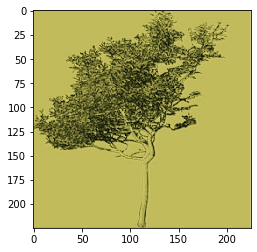

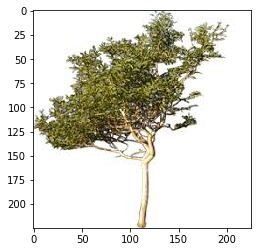

16
50625
(225, 225, 3)
50625
(225, 225, 3)


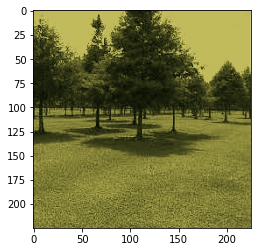

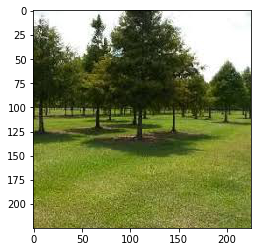

17
50625
(225, 225, 3)
50625
(225, 225, 3)


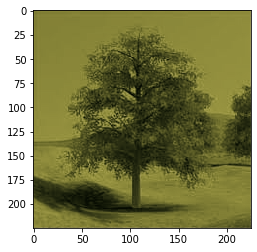

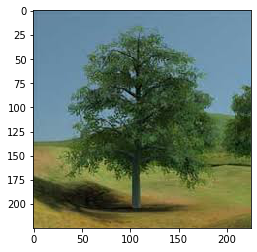

In [0]:

count = 10
for test_img, test_out in zip(test_imgs, test_outs):
    print(count)
    test_img = test_img/255.0
    test_out = test_out/255.0
    prediction = nn.predict(test_img)
    img = convert_output_image(prediction, images[-1].shape)
    plt.figure()
    plt.imshow(img)
    

    # Actual Image
    img = convert_output_image(test_out, images[-1].shape)
    plt.figure()
    plt.imshow(img)
    plt.show()
    count += 1